# Image Data Preprocessing

## Checking images in color format

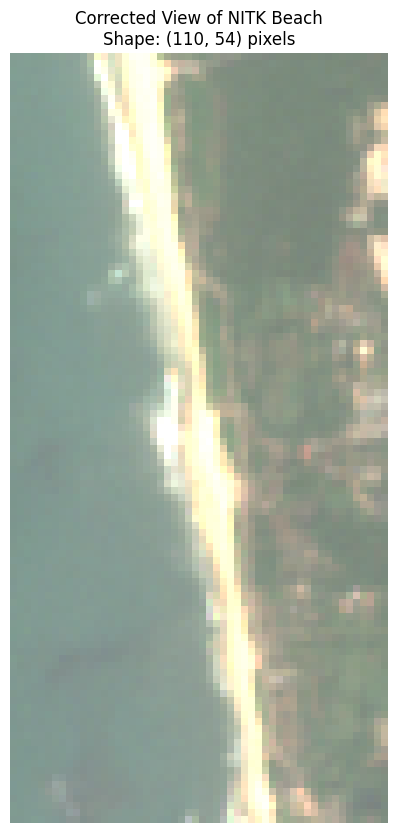

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# REPLACE '/content/drive/MyDrive/nitk_images/20161108T053442_20161108T053441_T43PDQ.tif' with the actual name of one file you downloaded
image_path = '/content/drive/MyDrive/nitk_images/20161108T053442_20161108T053441_T43PDQ.tif'

try:
    with rasterio.open(image_path) as src:
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)

        # Stack them into a color image
        img = np.dstack((red, green, blue))

        # The Fix: Normalization
        img = img / 3000.0
        img = np.clip(img, 0, 1)

        # Plot it Big
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Corrected View of NITK Beach\nShape: {red.shape} pixels")
        plt.axis('off')
        plt.show()

except Exception as e:
    print("Error:", e)
    print("Tip: Make sure you updated the 'image_path' variable!")

## Rating images using Otsu's Method

--- IMAGE QUALITY REPORT ---
Separability Score: 0.6255
⚠️ VERDICT: OKAY. It might need some manual cleaning, but it's usable.


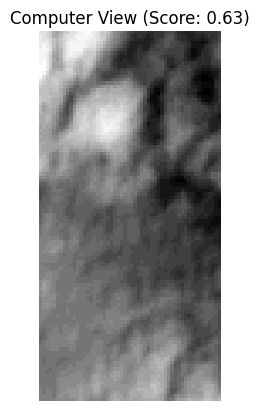

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rate_my_image(image_path):
    # 1. Load Image
    # '0' flag loads it in Grayscale directly, which is what the algorithm sees
    img = cv2.imread(image_path, 0)

    if img is None:
        print("Error: Image not found. Check the path!")
        return

    # 2. Calculate the 'Separability' (Otsu's Method)
    # This measures how easy it is to draw a line between 'Dark' (Water) and 'Bright' (Land)

    # Calculate Histogram
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])

    # Normalize
    total_pixels = img.size
    hist_norm = hist / total_pixels

    # Calculate Total Variance in the image
    mean_total = np.sum(np.arange(256) * hist_norm)
    var_total = np.sum(((np.arange(256) - mean_total) ** 2) * hist_norm)

    # Find Best Threshold (Otsu's Algorithm)
    best_var_between = 0
    current_prob_w0 = 0
    current_mean_w0_accum = 0

    for t in range(256):
        prob = hist_norm[t]
        if prob == 0: continue

        # Update Weights
        current_prob_w0 += prob
        current_prob_w1 = 1 - current_prob_w0
        if current_prob_w1 == 0: break

        # Update Means
        current_mean_w0_accum += t * prob
        mean_w0 = current_mean_w0_accum / current_prob_w0
        mean_w1 = (mean_total - current_mean_w0_accum) / current_prob_w1

        # Calculate Variance Between Classes
        var_between = current_prob_w0 * current_prob_w1 * ((mean_w0 - mean_w1) ** 2)

        if var_between > best_var_between:
            best_var_between = var_between

    # 3. Final Score Calculation (0.0 to 1.0)
    score = best_var_between / var_total if var_total > 0 else 0

    # 4. Verdict
    print(f"--- IMAGE QUALITY REPORT ---")
    print(f"Separability Score: {score:.4f}")

    if score > 0.7:
        print("✅ VERDICT: EXCELLENT. The computer sees a clear difference between water and land.")
    elif score > 0.5:
        print("⚠️ VERDICT: OKAY. It might need some manual cleaning, but it's usable.")
    else:
        print("❌ VERDICT: FAIL. The image is too uniform. Try downloading a clearer day.")

    # Show the image for sanity check
    plt.imshow(img, cmap='gray')
    plt.title(f"Computer View (Score: {score:.2f})")
    plt.axis('off')
    plt.show()

# --- RUN IT ---
# Replace this with the filename of the image you downloaded
rate_my_image('/content/drive/MyDrive/nitk_images/20190216T051901_20190216T052953_T43PDQ.tif')

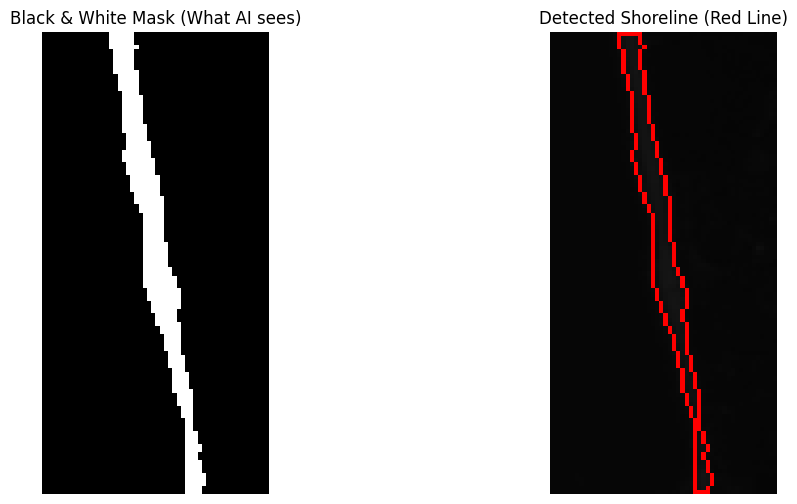

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_shoreline(image_path):
    # 1. Read Image
    # Load as Grayscale (0 flag) because we only care about intensity (Dark vs Light)
    img = cv2.imread(image_path, 0)

    if img is None:
        print("Error: Could not read image.")
        return

    # 2. Apply Gaussian Blur
    # This smoothes out the 'dots' (waves/noise) so the line isn't jagged
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # 3. Otsu's Thresholding
    # This automatically finds the "magic number" to split Water (0) from Land (255)
    # ret is the threshold value, thresh is the black/white image
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Find the "Edge" (Contours)
    # This walks along the boundary between Black and White pixels
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 5. Visualization
    # Convert grayscale back to RGB so we can draw a RED line on it
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Draw all found contours in Red (0, 0, 255) with thickness 1
    cv2.drawContours(img_color, contours, -1, (255, 0, 0), 1)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Black & White Mask (What AI sees)")
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Detected Shoreline (Red Line)")
    plt.imshow(img_color)
    plt.axis('off')

    plt.show()

# --- RUN IT ---
# Use the same image file you tested before
extract_shoreline('/content/drive/MyDrive/nitk_images/20231227T052229_20231227T052738_T43PDQ.tif')

## Image Quality Score of Each Image

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

# 1. Mount Google Drive (if not already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Set your folder path
# Make sure this matches exactly where your images are
folder_path = '/content/drive/MyDrive/nitk_images/'

def get_otsu_score(image_path):
    """
    Reads an image and calculates how well separated the Water vs Land is.
    Returns a score between 0.0 (Bad) and 1.0 (Perfect).
    """
    # Read as grayscale
    img = cv2.imread(image_path, 0)

    if img is None:
        return 0.0 # Skip unreadable files

    # Calculate Histogram
    hist, _ = np.histogram(img.flatten(), 256, [0, 256])

    # Normalize histogram
    total_pixels = img.size
    hist_norm = hist / total_pixels

    # Calculate Total Variance (Global)
    # The spread of pixel values across the whole image
    mean_total = np.sum(np.arange(256) * hist_norm)
    var_total = np.sum(((np.arange(256) - mean_total) ** 2) * hist_norm)

    if var_total == 0: return 0.0

    # Find Best Threshold (Otsu's logic manually to get the variance)
    best_var_between = 0
    current_prob_w0 = 0
    current_mean_w0_accum = 0

    # We iterate 0 to 255 to find the split that maximizes contrast
    for t in range(256):
        prob = hist_norm[t]
        if prob == 0: continue

        # Update weights (probabilities)
        current_prob_w0 += prob
        current_prob_w1 = 1 - current_prob_w0
        if current_prob_w1 == 0: break

        # Update means
        current_mean_w0_accum += t * prob
        mean_w0 = current_mean_w0_accum / current_prob_w0
        mean_w1 = (mean_total - current_mean_w0_accum) / current_prob_w1

        # Calculate Between-Class Variance
        var_between = current_prob_w0 * current_prob_w1 * ((mean_w0 - mean_w1) ** 2)

        if var_between > best_var_between:
            best_var_between = var_between

    # Final Score
    return best_var_between / var_total

# 3. Main Loop
data = []
print(f"Scanning images in: {folder_path}")

# List all files
files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

for i, filename in enumerate(files):
    file_path = os.path.join(folder_path, filename)

    # Get the score
    score = get_otsu_score(file_path)

    # Add to list
    data.append({'Image Name': filename, 'Score': score})

    # Progress print every 10 images
    if i % 10 == 0:
        print(f"Processed {i}/{len(files)}: {filename} -> Score: {score:.3f}")

# 4. Create DataFrame
df = pd.DataFrame(data)

# Sort by Score (High to Low) so best images are first
df = df.sort_values(by='Score', ascending=False).reset_index(drop=True)

# 5. Display Result
print("\n--- TOP 10 BEST IMAGES ---")
print(df.head(10))

# Optional: Save to CSV in your Drive so you don't have to run this again
csv_path = os.path.join(folder_path, 'image_quality_scores.csv')
df.to_csv(csv_path, index=False)
print(f"\nSaved full list to: {csv_path}")

# Shoreline Movement at NITK Beach (2016-2023)


Analyzing 98 valid images...
Analysis Complete!
        Date  Shoreline_Index
0 2016-11-08        25.212121
1 2016-12-28        26.588889
2 2017-02-16        26.322581
3 2017-12-28        25.595238
4 2018-02-21        26.657895


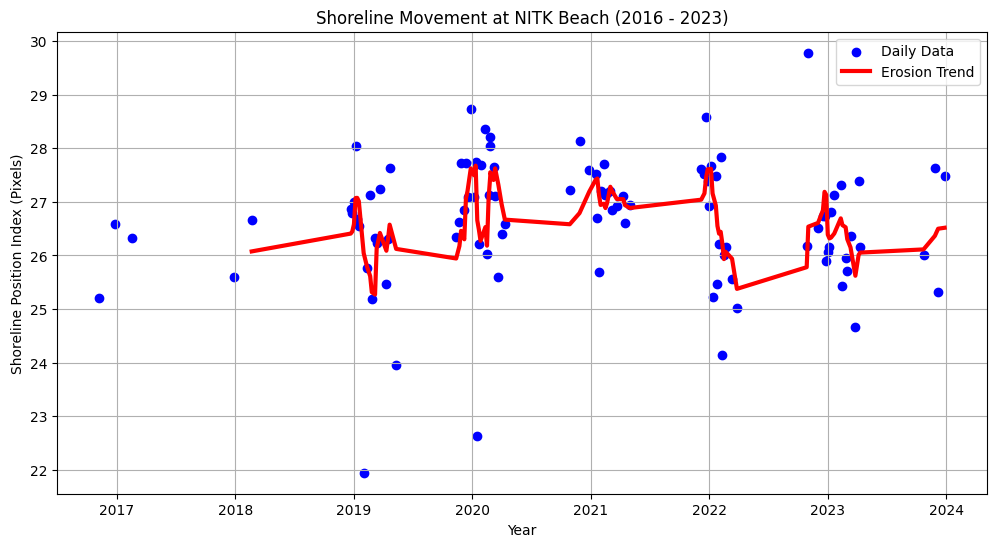

In [10]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. SETUP
# ---------------------------------------------------------
# Define the threshold for a "Good" image
SCORE_THRESHOLD = 0.75

# If you lost 'df', re-run the previous scoring block or load the CSV
good_images = df[df['Score'] > SCORE_THRESHOLD].copy()

# Sort by filename to ensure chronological order (Oldest -> Newest)
good_images = good_images.sort_values(by='Image Name')

print(f"Analyzing {len(good_images)} valid images...")


# 2. HELPER FUNCTIONS
# ---------------------------------------------------------
def get_date_from_filename(filename):
    # Filename format is usually: 20160123T...tif
    # We take the first 8 characters: 20160123
    date_str = filename[:8]
    return pd.to_datetime(date_str, format='%Y%m%d')

def get_shoreline_position(image_path):
    # Read Image
    img = cv2.imread(image_path, 0)
    if img is None: return None

    # Preprocessing (Blur + Otsu)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours: return None

    # Find the LARGEST contour (Assume this is the main beach line)
    # We ignore small islands or noise
    largest_contour = max(contours, key=cv2.contourArea)

    # --- CIVIL ENG CALCULATION ---
    # We want to know: "How far East is the water?"
    # The contour is a list of (x, y) points.
    # We calculate the AVERAGE X-Coordinate of the shoreline.
    # If this number gets bigger, the water is moving Right (Inland).

    # Extract just the X coordinates from the contour
    x_coords = largest_contour[:, 0, 0]

    # Return the average X position (in pixels)
    return np.mean(x_coords)


# 3. MAIN LOOP
# ---------------------------------------------------------
results = []
folder_path = '/content/drive/MyDrive/nitk_images/'

for index, row in good_images.iterrows():
    fname = row['Image Name']
    fpath = os.path.join(folder_path, fname)

    # Get Date
    try:
        date = get_date_from_filename(fname)
    except:
        continue # Skip if filename format is weird

    # Get Position
    position = get_shoreline_position(fpath)

    if position is not None:
        results.append({'Date': date, 'Shoreline_Index': position})

# Convert to DataFrame
erosion_df = pd.DataFrame(results)
print("Analysis Complete!")
print(erosion_df.head())

# 4. PRELIMINARY PLOT
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.scatter(erosion_df['Date'], erosion_df['Shoreline_Index'], color='blue', label='Daily Data')

# Add a Trendline (Rolling Average) to smooth out noise
# This shows the "Annual Trend"
erosion_df = erosion_df.sort_values(by='Date')
erosion_df['Trend'] = erosion_df['Shoreline_Index'].rolling(window=5).mean()

plt.plot(erosion_df['Date'], erosion_df['Trend'], color='red', linewidth=3, label='Erosion Trend')

plt.title(f"Shoreline Movement at NITK Beach ({erosion_df['Date'].dt.year.min()} - {erosion_df['Date'].dt.year.max()})")
plt.xlabel("Year")
plt.ylabel("Shoreline Position Index (Pixels)")
plt.legend()
plt.grid(True)
plt.show()

# Future Prediction By Analysing Previous Trend

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


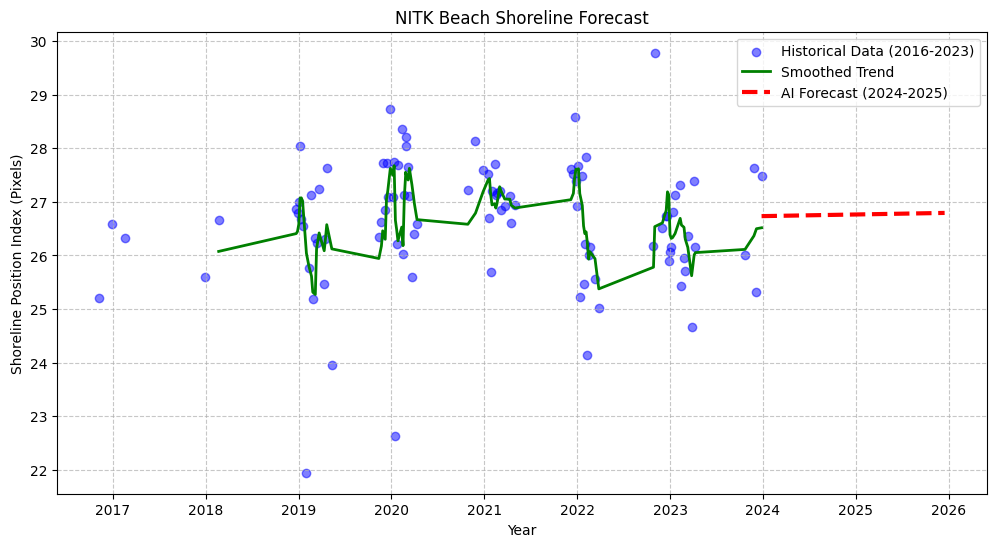

Estimated Erosion Rate: 0.0304 pixels per year
Conclusion: The beach is ERODING.


In [12]:
from sklearn.linear_model import LinearRegression
import datetime

# 1. PREPARE DATA FOR AI
# Machines can't read dates like "2023-01-01", so we convert them to numbers
# (Number of days since the first data point)
erosion_df['Date_Ordinal'] = erosion_df['Date'].map(datetime.datetime.toordinal)

# Define X (Time) and Y (Shoreline Position)
X = erosion_df[['Date_Ordinal']]
y = erosion_df['Shoreline_Index']

# 2. TRAIN THE MODEL
model = LinearRegression()
model.fit(X, y)

# 3. MAKE FUTURE PREDICTION (Next 2 Years / ~730 Days)
last_date = erosion_df['Date'].max()
future_dates = [last_date + datetime.timedelta(days=x) for x in range(0, 730, 30)] # Monthly steps
future_dates_ordinal = [[d.toordinal()] for d in future_dates]

future_pred = model.predict(future_dates_ordinal)

# 4. PLOT EVERYTHING
plt.figure(figsize=(12, 6))

# Historical Data
plt.scatter(erosion_df['Date'], erosion_df['Shoreline_Index'], color='blue', alpha=0.5, label='Historical Data (2016-2023)')
plt.plot(erosion_df['Date'], erosion_df['Trend'], color='green', linewidth=2, label='Smoothed Trend')

# Prediction
plt.plot(future_dates, future_pred, color='red', linestyle='--', linewidth=3, label='AI Forecast (2024-2025)')

plt.title("NITK Beach Shoreline Forecast")
plt.xlabel("Year")
plt.ylabel("Shoreline Position Index (Pixels)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Save this graph for your GitHub
plt.savefig('nitk_shoreline_forecast.png', dpi=300)
plt.show()

# Print the Rate of Erosion
slope = model.coef_[0] * 365 # Change per year
print(f"Estimated Erosion Rate: {slope:.4f} pixels per year")
if slope > 0:
    print("Conclusion: The beach is ERODING.")
else:
    print("Conclusion: The beach is GROWING (Accretion).")